# End-to-end Pipeline for YoloV4 Model Training

In [1]:
import boto3
import json
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
from sagemaker.session import Session

sess = Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
role = get_execution_role()

In this notebook, we will use a base implementation of the Yolov4 architecture which uses the PyTorch framework. We are using a forked version of this repo (https://github.com/Tianxiaomo/pytorch-YOLOv4) which has been modified for training with custom datasets. We have also made some minor adjustments to the forked repository to accomodate Amazon SageMaker Training.

Before we train our model, we need to create our training container image and ensure our dataset is in the appropriate format for PyTorch Yolov4 models.

## Create Docker training image

In [ ]:
!pip install sagemaker-studio-image-build

In [10]:
%%sh

cd train

chmod +x train.py
chmod +x dataset.py

sm-docker build . --repository yolov4-e2e-example:latest

Created ECR repository yolov4-e2e-example
....................[Container] 2021/07/20 03:32:45 Waiting for agent ping

[Container] 2021/07/20 03:32:48 Waiting for DOWNLOAD_SOURCE
[Container] 2021/07/20 03:32:48 Phase is DOWNLOAD_SOURCE
[Container] 2021/07/20 03:32:48 CODEBUILD_SRC_DIR=/codebuild/output/src401825733/src
[Container] 2021/07/20 03:32:48 YAML location is /codebuild/output/src401825733/src/buildspec.yml
[Container] 2021/07/20 03:32:48 Processing environment variables
[Container] 2021/07/20 03:32:48 No runtime version selected in buildspec.
[Container] 2021/07/20 03:32:48 Moving to directory /codebuild/output/src401825733/src
[Container] 2021/07/20 03:32:48 Registering with agent
[Container] 2021/07/20 03:32:48 Phases found in YAML: 3
[Container] 2021/07/20 03:32:48  PRE_BUILD: 9 commands
[Container] 2021/07/20 03:32:48  BUILD: 4 commands
[Container] 2021/07/20 03:32:48  POST_BUILD: 3 commands
[Container] 2021/07/20 03:32:48 Phase complete: DOWNLOAD_SOURCE State: SUCCEEDED
[C

## Upload dataset to Amazon S3

For this step, we will upload our dataset to Amazon S3 so we can easily load the data into our container during model training.

In this demo, I am leveraging an open-source dataset provided by Roboflow: https://public.roboflow.com/object-detection/uno-cards

It is free to create an account and they have an easy export option for PyTorch Yolov4 compatible datasets.

Once you have your dataset, we can upload our data to Amazon S3. It is best to separate your training, validation, and testing data into 3 folders in S3.

## Create the estimator

### Set up parameters & imports

In [2]:
# Image URI for your docker training image
docker_img_uri = "221110525845.dkr.ecr.ap-east-1.amazonaws.com/yolov4-e2e-example:latest"
training_job_name = name_from_base('torch-yolov4-model')
#training_job_name = "torch-yolov4-model-2021-07-20-12-54-22-058"

# Location where the trained model resides in S3
model_path = f"s3://{bucket}/{training_job_name}/output/model.tar.gz"

# Input shape and layer name
input_shape = [1,3,416,416]
input_layer_name = 'input0'
data_shape = json.dumps({input_layer_name: input_shape})

# Compiled model path for model compiled with Sagemaker Neo
compiled_model_path = f"s3://{bucket}/{training_job_name}/models/compiled"

# Number of classes in your dataset
n_classes = 15

### Create & train the estimator

In [17]:
estimator = Estimator(
    image_uri=docker_img_uri,
    role=role,
    instance_type="ml.g4dn.2xlarge",
    volume_size=50,
    instance_count=1,
    max_run = 6 * 60 * 60,
    hyperparameters={
        "pretrained": "yolov4.conv.137.pth",
        "classes": n_classes,
        "train_label": "_annotations.txt", # If your annotations file is named differently, please note the correct name here
        "val_label": "_annotations.txt", # If your annotations file is named differently, please note the correct name here
        "batch": 2,
        "subdivisions": 1,
        "learning_rate": 0.001,
        "gpu": "0",
        "epochs": 5
    }
)

In [ ]:
estimator.fit(job_name=training_job_name, inputs={
    "train": f"s3://{bucket}/yolov4_training_data/train/", # The location in S3 where your training data and training annotations are stored
    "val": f"s3://{bucket}/yolov4_training_data/valid/" # The location in S3 where your validation data and validation annotations are stored
})

2021-07-20 12:54:26 Starting - Starting the training job...
2021-07-20 12:54:27 Starting - Launching requested ML instancesProfilerReport-1626785666: InProgress
...
2021-07-20 12:55:13 Starting - Preparing the instances for training............
2021-07-20 12:57:23 Downloading - Downloading input data...
2021-07-20 12:57:44 Training - Downloading the training image.........
2021-07-20 12:59:24 Training - Training image download completed. Training in progress.log file path:log/log_2021-07-20_12-59-09.txt
2021-07-20 12:59:09,616 train.py[line:366] INFO: ---hyper parameters--
2021-07-20 12:59:09,616 train.py[line:367] INFO: {
  "pretrained": "yolov4.conv.137.pth",
  "train_label": "_annotations.txt",
  "classes": "15",
  "batch": "2",
  "val_label": "_annotations.txt",
  "epochs": "5",
  "gpu": "0",
  "learning_rate": "0.001",
  "subdivisions": "1"
}
2021-07-20 12:59:09,616 train.py[line:368] INFO: ----
2021-07-20 12:59:09,923 train.py[line:427] INFO: Using device cuda
2021-07-20 12:59:14

## Prepare trained model

In [7]:
s3_client = boto3.client('s3')

with open('model.tar.gz', 'wb') as data:
    s3_client.download_fileobj(Bucket=bucket, Key=f'{training_job_name}/output/model.tar.gz', Fileobj=data)
weightfile = 'yolov4-trained-model.pth'

In [8]:
!tar -zxvf model.tar.gz

yolov4-trained-model.pth


In [9]:
import torch
import models

model = models.Yolov4(n_classes=n_classes)
pretrained_dict = torch.load(weightfile, map_location=torch.device('cpu'))
model.load_state_dict(pretrained_dict)
model.eval()

Yolov4(
  (down1): DownSample1(
    (conv1): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv2): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv3): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv4): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNo

In [10]:
input1 = torch.zeros(input_shape).float()

trace = torch.jit.trace(model.eval().float(), input1)
trace.save('model.pth')

[2021-07-22 08:57:14.903 pytorch-1-6-cpu-py36--ml-t3-medium-dad04bab849ac89fc91f4c4199ed:6643 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-22 08:57:15.445 pytorch-1-6-cpu-py36--ml-t3-medium-dad04bab849ac89fc91f4c4199ed:6643 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/opt/conda/lib/python3.6/site-packages/torch/jit/__init__.py:1109: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(method_name, func, example_inputs, var_lookup_fn, strict, _force_outplace)


Now we need to upload the `inference.py` entry point script so we can use it to create our model endpoint. Create a new folder called `code` and then upload the inference file into the new directory.

In [10]:
!mkdir code

In [11]:
!cp inference/* code/
!cp utils.py code/

In [8]:
!tar -czvf traced-yolov4-model.tar.gz model.pth code

model.pth
code/
code/utils.py
code/requirements.txt
code/inference.py


In [45]:
traced_model_path = sess.upload_data(path='traced-yolov4-model.tar.gz', key_prefix='models/traced')
print(traced_model_path)

s3://sagemaker-ap-east-1-221110525845/models/traced/traced-yolov4-model.tar.gz


## Deploy the model to SageMaker Endpoint

In [3]:
# Framework information
framework = 'PYTORCH'
framework_version = '1.6'
compilation_job_name = f"{training_job_name}-compilation"

sm_client = boto3.client('sagemaker', region_name=region)

In [5]:
env_vars = {"COMPILEDMODEL": 'False', 'MMS_MAX_RESPONSE_SIZE': '100000000', 'MMS_DEFAULT_RESPONSE_TIMEOUT': '120'}

In [6]:
from sagemaker.pytorch import PyTorchModel

# Create SageMaker model and deploy an endpoint
# This is for the non-optimized model.
uncompiled_model = PyTorchModel(
    model_data=f"s3://{bucket}/models/traced/traced-yolov4-model.tar.gz",#f"{compiled_model_path}/traced-yolov4-model-ml_g4dn.tar.gz",
    role=role,
    entry_point='code/inference.py',
    framework_version=framework_version,
    py_version='py3',
    env=env_vars
)

In [47]:
# Replace the example instance_type below to your preferred instance_type
predictor = uncompiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.g4dn.xlarge')

# Print the name of newly created endpoint
print(predictor.endpoint_name) 

INFO:sagemaker:Creating model with name: pytorch-inference-2021-07-20-20-42-38-981
INFO:sagemaker:Creating endpoint with name pytorch-inference-2021-07-20-20-42-39-219


---------------!pytorch-inference-2021-07-20-20-42-39-219


In [10]:
# Get deployed PyTorch endpoint 
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name="pytorch-inference-2021-07-20-20-42-39-219")

## Create the compiled model with SageMaker Neo

sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': traced_model_path,
        'DataInputConfig': data_shape,
        'Framework': framework,
        'FrameworkVersion': framework_version
    },
    OutputConfig={
        'S3OutputLocation': compiled_model_path,
        'TargetDevice': 'ml_g4dn'
    },
    StoppingCondition={ 'MaxRuntimeInSeconds': 900 }    
)

import time
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(10)

In [10]:
from sagemaker.pytorch import PyTorchModel

target_device = 'ml_g4dn'
framework = 'PYTORCH'
compiled_env = {"MMS_DEFAULT_WORKERS_PER_MODEL":'1', "TVM_NUM_THREADS": '36', "COMPILEDMODEL": 'True', 'MMS_MAX_RESPONSE_SIZE': '100000000', 'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'}
sm_model_compiled = PyTorchModel(model_data=f"s3://{bucket}/models/traced/traced-yolov4-model.tar.gz",
                                 framework_version = framework_version,
                                 role=role,
                                 sagemaker_session=sess,
                                 entry_point='code/inference.py',
                                 py_version='py3',
                                 env=compiled_env
                                )
compiled_model = sm_model_compiled.compile(target_instance_family=target_device, 
                                         input_shape=data_shape,
                                         job_name=compilation_job_name+'-v3',
                                         role=role,
                                         framework=framework.lower(),
                                         framework_version=framework_version,
                                         output_path=compiled_model_path
                                        )

????????????????????????.........................................!

In [11]:
compiled_model.env = compiled_env

In [12]:
optimized_predictor = compiled_model.deploy(initial_instance_count = 1,
                                  instance_type = 'ml.g4dn.xlarge'
                                 )

---------------!

Now that our endpoint is deployed, you can test with a sample image from your test set.

In [48]:
import boto3
import time

client = boto3.client('sagemaker-runtime', region_name='ap-east-1')

content_type = 'application/x-image'

img_name = "test/019477314_jpg.rf.4c7a19e36c13ecd7416f25577b55f568.jpg" # Add your image here

with open(img_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

t0 = time.time()
response = client.invoke_endpoint(EndpointName=predictor.endpoint_name, Body=payload, ContentType=content_type)
t1 = time.time()
uncompiled_elapsed = (t1-t0)*1000

#t0 = time.time()
#response = client.invoke_endpoint(EndpointName=optimized_predictor.endpoint_name, Body=payload, ContentType=content_type)
#t1 = time.time()
#compiled_elapsed = (t1-t0)*1000

#print(f'c - {compiled_elapsed} ms . uc - {uncompiled_elapsed} ms')

stream_body = response['Body']

In [49]:
from sagemaker.deserializers import NumpyDeserializer

deser = NumpyDeserializer()
temp_boxes = deser.deserialize(stream_body, 'application/x-npy')

In [50]:
import math
from PIL import Image, ImageDraw, ImageFont

def plot_boxes(img, boxes, savename=None, class_names=None):
    colors = torch.FloatTensor([[1, 0, 1], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 1, 0], [1, 0, 0]]);

    def get_color(c, x, max_val):
        ratio = float(x) / max_val * 5
        i = int(math.floor(ratio))
        j = int(math.ceil(ratio))
        ratio = ratio - i
        r = (1 - ratio) * colors[i][c] + ratio * colors[j][c]
        return int(r * 255)

    width = img.width
    height = img.height
    draw = ImageDraw.Draw(img)
    for i in range(len(boxes)):
        box = boxes[i]
        x1 = (box[0] - box[2] / 2.0) * width
        y1 = (box[1] - box[3] / 2.0) * height
        x2 = (box[0] + box[2] / 2.0) * width
        y2 = (box[1] + box[3] / 2.0) * height
        
        rgb = (255, 0, 0)
        if len(box) >= 7 and class_names:
            cls_conf = box[5]
            cls_id = int(box[6])
            
            print('%s: %f' % (class_names[cls_id], cls_conf))
            classes = len(class_names)
            offset = cls_id * 123457 % classes
            red = get_color(2, offset, classes)
            green = get_color(1, offset, classes)
            blue = get_color(0, offset, classes)
            rgb = (red, green, blue)
            draw.text((x1, y1), class_names[cls_id], fill=rgb)
        draw.rectangle([x1, y1, x2, y2], outline=rgb)
    if savename:
        print("save plot results to %s" % savename)
        img.save(savename)
    return img

0: 0.886346
9: 0.989515
6: 0.997701
save plot results to predictions.jpg


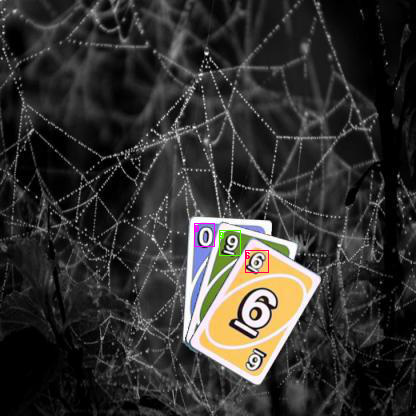

In [51]:
import utils
from PIL import Image

class_names = utils.load_class_names('test/dataset.names')

img = Image.open(img_name).convert('RGB')
plot_boxes(img, temp_boxes, 'test/predictions.jpg', class_names)

## Configure Autoscaling

In [21]:
#Let us define a client to play with autoscaling options
client = boto3.client('application-autoscaling') # Common class representing Application Auto Scaling for SageMaker amongst other services

endpoint_name = 'sagemaker-inference-pytorch-ml-g4dn-2021-07-21-05-29-42-525'
resource_id='endpoint/' + endpoint_name + '/variant/' + 'AllTraffic' # This is the format in which application autoscaling references the endpoint

response = client.register_scalable_target(
    ServiceNamespace='sagemaker', #
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=2
)

#Example 1 - SageMakerVariantInvocationsPerInstance Metric
response = client.put_scaling_policy(
    PolicyName='Invocations-ScalingPolicy',
    ServiceNamespace='sagemaker', # The namespace of the AWS service that provides the resource. 
    ResourceId=resource_id, # Endpoint name 
    ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
    PolicyType='TargetTrackingScaling', # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 10.0, # The target value for the metric. - here the metric is - SageMakerVariantInvocationsPerInstance
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance', # is the average number of times per minute that each instance for a variant is invoked. 
        },
        'ScaleInCooldown': 600, # The cooldown period helps you prevent your Auto Scaling group from launching or terminating 
                                # additional instances before the effects of previous activities are visible. 
                                # You can configure the length of time based on your instance startup time or other application needs.
                                # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start. 
        'ScaleOutCooldown': 300 # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.
        
        # 'DisableScaleIn': True|False - ndicates whether scale in by the target tracking policy is disabled. 
                            # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
    }
)

#Example 2 - CPUUtilization metric
response = client.put_scaling_policy(
    PolicyName='CPUUtil-ScalingPolicy',
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 90.0,
        'CustomizedMetricSpecification':
        {
            'MetricName': 'CPUUtilization',
            'Namespace': '/aws/sagemaker/Endpoints',
            'Dimensions': [
                {'Name': 'EndpointName', 'Value': endpoint_name },
                {'Name': 'VariantName','Value': 'AllTraffic'}
            ],
            'Statistic': 'Average', # Possible - 'Statistic': 'Average'|'Minimum'|'Maximum'|'SampleCount'|'Sum'
            'Unit': 'Percent'
        },
        'ScaleInCooldown': 600,
        'ScaleOutCooldown': 300
    }
)

In [46]:
# Load Test for Autoscaling
for i in range(5000):
    response = client.invoke_endpoint(EndpointName=predictor.endpoint_name, Body=payload, ContentType=content_type)

In [22]:
response = client.delete_scaling_policy(
    PolicyName='Invocations-ScalingPolicy',
    ServiceNamespace='sagemaker', # The namespace of the AWS service that provides the resource. 
    ResourceId=resource_id, # Endpoint name 
    ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
)

response = client.delete_scaling_policy(
    PolicyName='CPUUtil-ScalingPolicy',
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount'
)